In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
import shap
import seaborn as sns

def calculate_correlations(shap_values, features_df, feature_names, num_classes):
    correlation_df = pd.DataFrame()

    for feature in feature_names:
        correlation_dict = {'feature': feature}

        for i in range(num_classes):
            shap_values_i = shap_values[i][:, features_df.columns.get_loc(feature)]
            feature_values_i = features_df[feature].values

            correlation_coefficient_i = np.corrcoef(shap_values_i, feature_values_i)[0, 1]
            correlation_dict[f'correlation_{i}'] = correlation_coefficient_i

        correlation_df = correlation_df.append(correlation_dict, ignore_index=True)

    return correlation_df

def XGBoost(X, y):
    # データを訓練用とテスト用に分割
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # 訓練データをさらに訓練用と検証用に分割
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

    # モデルのパラメータを設定(CPU)
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'num_class' : 5,
        'eta': 0.1,
        'max_depth': 4,
        'seed': 0,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }
    
    # データをpandas.DataFrame形式で保存
    #X_train_df = pd.DataFrame(X_train, columns=column_names)
    #y_train_df = pd.DataFrame(y_train, columns=column_names)

    # 訓練データと検証データをXGBoostのDMatrix形式に変換
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 訓練データと検証データのセットをリストに格納
    evals = [(dtrain, 'train'), (dval, 'eval')]

    # モデルを訓練
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=evals, early_stopping_rounds=100)

    # テストデータをDMatrix形式に変換
    dtest = xgb.DMatrix(X_test)

    # 訓練データで予測
    y_train_pred = bst.predict(dtrain)

    # テストデータで予測
    y_pred = bst.predict(dtest)

    # 評価
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_accuracy*100:.2f}%")

    # 評価
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
        
    return X_train, y_train, bst

def normalize_per_state(df, start, end):
    scaler = StandardScaler()
    df.iloc[start:end, :] = scaler.fit_transform(df.iloc[start:end, :])
    return df

In [13]:
# 1秒ごとのデータに分割
#n_samples_per_second = 128  # 128Hzのサンプリングレート
#total_seconds = 10  # 全体の秒数

# データの読み込み
#df = pd.read_csv('ALL.csv') # 99.74%
df = pd.read_csv('ReALL.csv') 
#df = pd.read_csv('ALL_RightLeft.csv') # 99.84%
#df = pd.read_csv('ALL_UpperUnder.csv') # 99.79%
#df_y = pd.read_csv('H_all.csv')
#df_y = pd.read_csv('H_RL.csv')

#df = pd.concat([df,df_y])

"""""
# チャンネルごとに正規化
scaler = StandardScaler()
for column in df.columns[:-1]:  # 'State'列を除くすべての列
    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
"""""

'""\n# チャンネルごとに正規化\nscaler = StandardScaler()\nfor column in df.columns[:-1]:  # \'State\'列を除くすべての列\n    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))\n'

In [14]:
# Hzごと
# 特徴量と目的変数を抽出する
X = df.drop('Label', axis=1)  # 'Label'以外の列
#X = df.drop(['Label','T8','T7'],axis=1)
#X = df[["C1", "C2", "C3", "C4", "Cz", "CPz","T7","T8"]] # 
#X = df[["Cz","C3","Pz","P3","P4"]]
y = df['Label']  # 'Label'を目標変数

#XGBoost
X_train_df, y_train_df, bst = XGBoost(X, y)

[0]	train-mlogloss:1.37920	eval-mlogloss:1.38027
[1]	train-mlogloss:1.20027	eval-mlogloss:1.20272
[2]	train-mlogloss:1.05542	eval-mlogloss:1.05842
[3]	train-mlogloss:0.93368	eval-mlogloss:0.93661
[4]	train-mlogloss:0.83080	eval-mlogloss:0.83425
[5]	train-mlogloss:0.74198	eval-mlogloss:0.74556
[6]	train-mlogloss:0.66488	eval-mlogloss:0.66859
[7]	train-mlogloss:0.59712	eval-mlogloss:0.60138
[8]	train-mlogloss:0.53751	eval-mlogloss:0.54251
[9]	train-mlogloss:0.48459	eval-mlogloss:0.48969
[10]	train-mlogloss:0.43689	eval-mlogloss:0.44234
[11]	train-mlogloss:0.39467	eval-mlogloss:0.40065
[12]	train-mlogloss:0.35672	eval-mlogloss:0.36284
[13]	train-mlogloss:0.32278	eval-mlogloss:0.32924
[14]	train-mlogloss:0.29253	eval-mlogloss:0.29922
[15]	train-mlogloss:0.26522	eval-mlogloss:0.27200
[16]	train-mlogloss:0.24091	eval-mlogloss:0.24777
[17]	train-mlogloss:0.21857	eval-mlogloss:0.22551
[18]	train-mlogloss:0.19868	eval-mlogloss:0.20565
[19]	train-mlogloss:0.18085	eval-mlogloss:0.18807
[20]	train

[163]	train-mlogloss:0.00140	eval-mlogloss:0.00340
[164]	train-mlogloss:0.00140	eval-mlogloss:0.00339
[165]	train-mlogloss:0.00140	eval-mlogloss:0.00338
[166]	train-mlogloss:0.00140	eval-mlogloss:0.00338
[167]	train-mlogloss:0.00139	eval-mlogloss:0.00338
[168]	train-mlogloss:0.00139	eval-mlogloss:0.00338
[169]	train-mlogloss:0.00139	eval-mlogloss:0.00338
[170]	train-mlogloss:0.00138	eval-mlogloss:0.00338
[171]	train-mlogloss:0.00138	eval-mlogloss:0.00338
[172]	train-mlogloss:0.00138	eval-mlogloss:0.00337
[173]	train-mlogloss:0.00138	eval-mlogloss:0.00337
[174]	train-mlogloss:0.00137	eval-mlogloss:0.00336
[175]	train-mlogloss:0.00137	eval-mlogloss:0.00337
[176]	train-mlogloss:0.00137	eval-mlogloss:0.00337
[177]	train-mlogloss:0.00137	eval-mlogloss:0.00336
[178]	train-mlogloss:0.00137	eval-mlogloss:0.00336
[179]	train-mlogloss:0.00136	eval-mlogloss:0.00336
[180]	train-mlogloss:0.00136	eval-mlogloss:0.00336
[181]	train-mlogloss:0.00136	eval-mlogloss:0.00335
[182]	train-mlogloss:0.00136	ev

[324]	train-mlogloss:0.00123	eval-mlogloss:0.00326
[325]	train-mlogloss:0.00123	eval-mlogloss:0.00325
[326]	train-mlogloss:0.00123	eval-mlogloss:0.00326
[327]	train-mlogloss:0.00123	eval-mlogloss:0.00326
[328]	train-mlogloss:0.00123	eval-mlogloss:0.00326
[329]	train-mlogloss:0.00123	eval-mlogloss:0.00326
[330]	train-mlogloss:0.00123	eval-mlogloss:0.00326
[331]	train-mlogloss:0.00123	eval-mlogloss:0.00326
[332]	train-mlogloss:0.00123	eval-mlogloss:0.00326
[333]	train-mlogloss:0.00123	eval-mlogloss:0.00325
[334]	train-mlogloss:0.00123	eval-mlogloss:0.00325
[335]	train-mlogloss:0.00123	eval-mlogloss:0.00325
[336]	train-mlogloss:0.00123	eval-mlogloss:0.00325
[337]	train-mlogloss:0.00123	eval-mlogloss:0.00325
[338]	train-mlogloss:0.00123	eval-mlogloss:0.00325
[339]	train-mlogloss:0.00123	eval-mlogloss:0.00325
[340]	train-mlogloss:0.00123	eval-mlogloss:0.00325
[341]	train-mlogloss:0.00122	eval-mlogloss:0.00325
[342]	train-mlogloss:0.00122	eval-mlogloss:0.00325
[343]	train-mlogloss:0.00122	ev

[485]	train-mlogloss:0.00117	eval-mlogloss:0.00310
[486]	train-mlogloss:0.00117	eval-mlogloss:0.00310
[487]	train-mlogloss:0.00117	eval-mlogloss:0.00309
[488]	train-mlogloss:0.00117	eval-mlogloss:0.00310
[489]	train-mlogloss:0.00117	eval-mlogloss:0.00309
[490]	train-mlogloss:0.00117	eval-mlogloss:0.00309
[491]	train-mlogloss:0.00117	eval-mlogloss:0.00309
[492]	train-mlogloss:0.00117	eval-mlogloss:0.00309
[493]	train-mlogloss:0.00117	eval-mlogloss:0.00309
[494]	train-mlogloss:0.00117	eval-mlogloss:0.00309
[495]	train-mlogloss:0.00117	eval-mlogloss:0.00309
[496]	train-mlogloss:0.00117	eval-mlogloss:0.00308
[497]	train-mlogloss:0.00117	eval-mlogloss:0.00308
[498]	train-mlogloss:0.00116	eval-mlogloss:0.00308
[499]	train-mlogloss:0.00116	eval-mlogloss:0.00308
[500]	train-mlogloss:0.00116	eval-mlogloss:0.00307
[501]	train-mlogloss:0.00116	eval-mlogloss:0.00307
[502]	train-mlogloss:0.00116	eval-mlogloss:0.00307
[503]	train-mlogloss:0.00116	eval-mlogloss:0.00307
[504]	train-mlogloss:0.00116	ev

[646]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[647]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[648]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[649]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[650]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[651]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[652]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[653]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[654]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[655]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[656]	train-mlogloss:0.00113	eval-mlogloss:0.00287
[657]	train-mlogloss:0.00113	eval-mlogloss:0.00288
[658]	train-mlogloss:0.00113	eval-mlogloss:0.00287
[659]	train-mlogloss:0.00113	eval-mlogloss:0.00287
[660]	train-mlogloss:0.00113	eval-mlogloss:0.00287
[661]	train-mlogloss:0.00113	eval-mlogloss:0.00287
[662]	train-mlogloss:0.00113	eval-mlogloss:0.00287
[663]	train-mlogloss:0.00113	eval-mlogloss:0.00287
[664]	train-mlogloss:0.00113	eval-mlogloss:0.00287
[665]	train-mlogloss:0.00113	ev

[807]	train-mlogloss:0.00111	eval-mlogloss:0.00274
[808]	train-mlogloss:0.00111	eval-mlogloss:0.00274
[809]	train-mlogloss:0.00111	eval-mlogloss:0.00274
[810]	train-mlogloss:0.00111	eval-mlogloss:0.00274
[811]	train-mlogloss:0.00111	eval-mlogloss:0.00274
[812]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[813]	train-mlogloss:0.00111	eval-mlogloss:0.00274
[814]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[815]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[816]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[817]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[818]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[819]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[820]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[821]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[822]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[823]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[824]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[825]	train-mlogloss:0.00111	eval-mlogloss:0.00273
[826]	train-mlogloss:0.00111	ev

[968]	train-mlogloss:0.00109	eval-mlogloss:0.00265
[969]	train-mlogloss:0.00109	eval-mlogloss:0.00265
[970]	train-mlogloss:0.00109	eval-mlogloss:0.00265
[971]	train-mlogloss:0.00109	eval-mlogloss:0.00265
[972]	train-mlogloss:0.00109	eval-mlogloss:0.00265
[973]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[974]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[975]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[976]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[977]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[978]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[979]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[980]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[981]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[982]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[983]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[984]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[985]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[986]	train-mlogloss:0.00109	eval-mlogloss:0.00264
[987]	train-mlogloss:0.00109	ev

[1127]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1128]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1129]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1130]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1131]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1132]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1133]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1134]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1135]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1136]	train-mlogloss:0.00108	eval-mlogloss:0.00257
[1137]	train-mlogloss:0.00108	eval-mlogloss:0.00258
[1138]	train-mlogloss:0.00108	eval-mlogloss:0.00257
[1139]	train-mlogloss:0.00108	eval-mlogloss:0.00257
[1140]	train-mlogloss:0.00108	eval-mlogloss:0.00257
[1141]	train-mlogloss:0.00108	eval-mlogloss:0.00257
[1142]	train-mlogloss:0.00108	eval-mlogloss:0.00257
[1143]	train-mlogloss:0.00108	eval-mlogloss:0.00257
[1144]	train-mlogloss:0.00108	eval-mlogloss:0.00257
[1145]	train-mlogloss:0.00108	eval-mlogloss:0.00257
[1146]	train

[1285]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1286]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1287]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1288]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1289]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1290]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1291]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1292]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1293]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1294]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1295]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1296]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1297]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1298]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1299]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1300]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1301]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1302]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1303]	train-mlogloss:0.00107	eval-mlogloss:0.00253
[1304]	train

[1443]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1444]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1445]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1446]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1447]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1448]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1449]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1450]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1451]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1452]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1453]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1454]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1455]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1456]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1457]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1458]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1459]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1460]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1461]	train-mlogloss:0.00107	eval-mlogloss:0.00249
[1462]	train

[1601]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1602]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1603]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1604]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1605]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1606]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1607]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1608]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1609]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1610]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1611]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1612]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1613]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1614]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1615]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1616]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1617]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1618]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1619]	train-mlogloss:0.00106	eval-mlogloss:0.00246
[1620]	train

[1759]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1760]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1761]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1762]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1763]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1764]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1765]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1766]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1767]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1768]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1769]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1770]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1771]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1772]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1773]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1774]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1775]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1776]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1777]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1778]	train

[1917]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1918]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1919]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1920]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1921]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1922]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1923]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1924]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1925]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1926]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1927]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1928]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1929]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1930]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1931]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1932]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1933]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1934]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[1935]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[1936]	train

[2075]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[2076]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2077]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[2078]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2079]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[2080]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2081]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[2082]	train-mlogloss:0.00106	eval-mlogloss:0.00244
[2083]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2084]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2085]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2086]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2087]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2088]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2089]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2090]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2091]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2092]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2093]	train-mlogloss:0.00106	eval-mlogloss:0.00245
[2094]	train

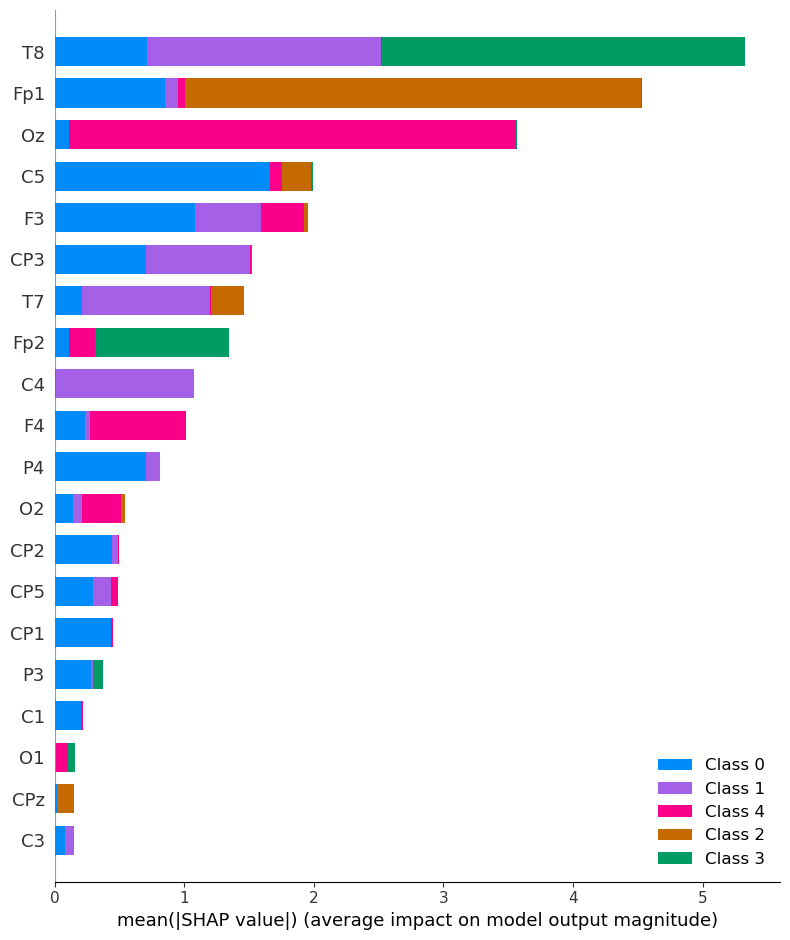

In [15]:
#各特徴重要度を表示する
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train_df,y_train_df)

shap.summary_plot(shap_values, X_train_df)
#0 普通
#1 右手
#2 左手
#3 右足
#4 左足

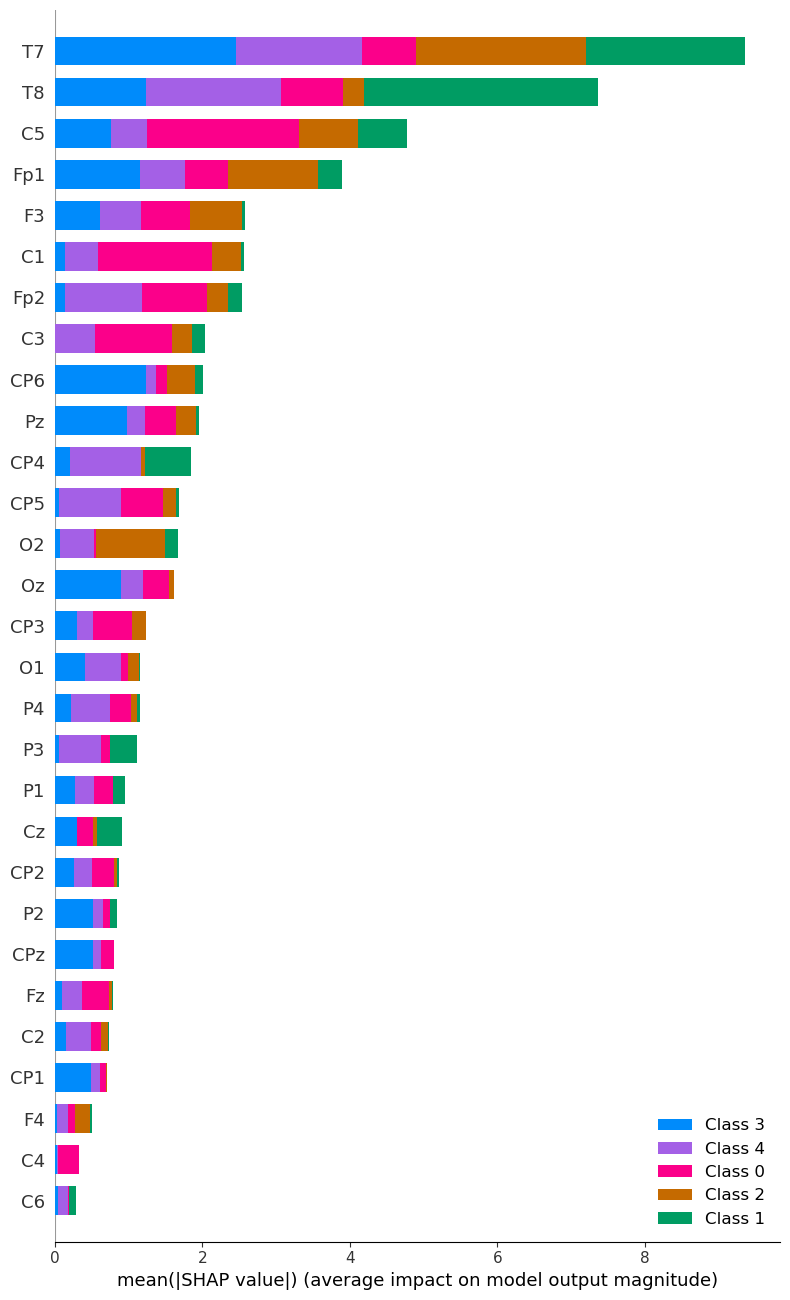

In [12]:
# SHAP値をプロット
shap.summary_plot(shap_values[0], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[0], X_train_df)
# 普通

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


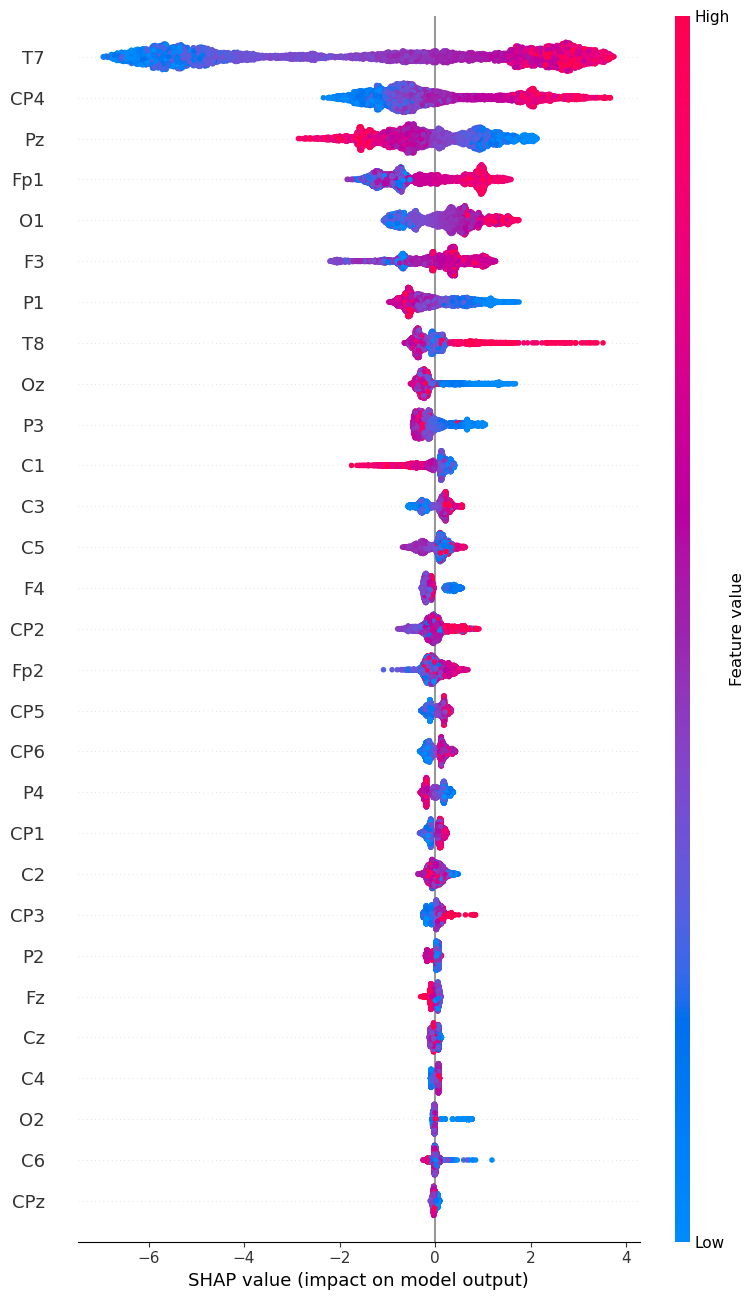

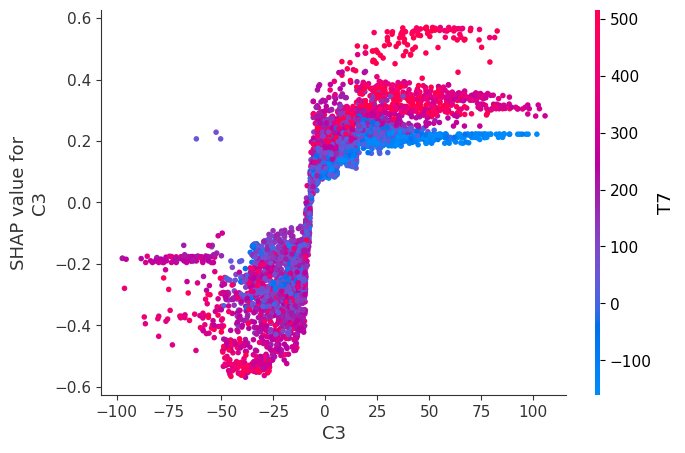

In [45]:
# SHAP値をプロット
shap.summary_plot(shap_values[1], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
shap.dependence_plot("C3", shap_values[1], X_train_df)
# 右手

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


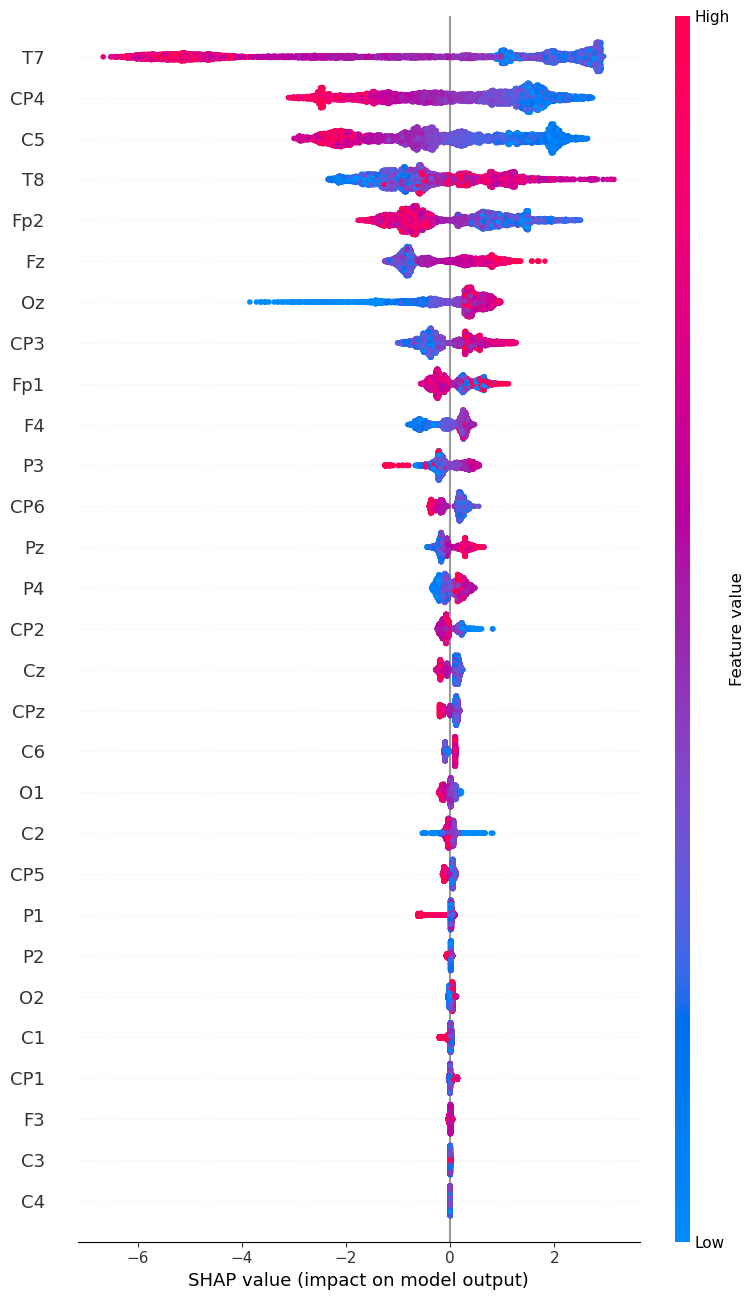

In [46]:
# SHAP値をプロット
shap.summary_plot(shap_values[2], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[1], X_train_df)
# 左手

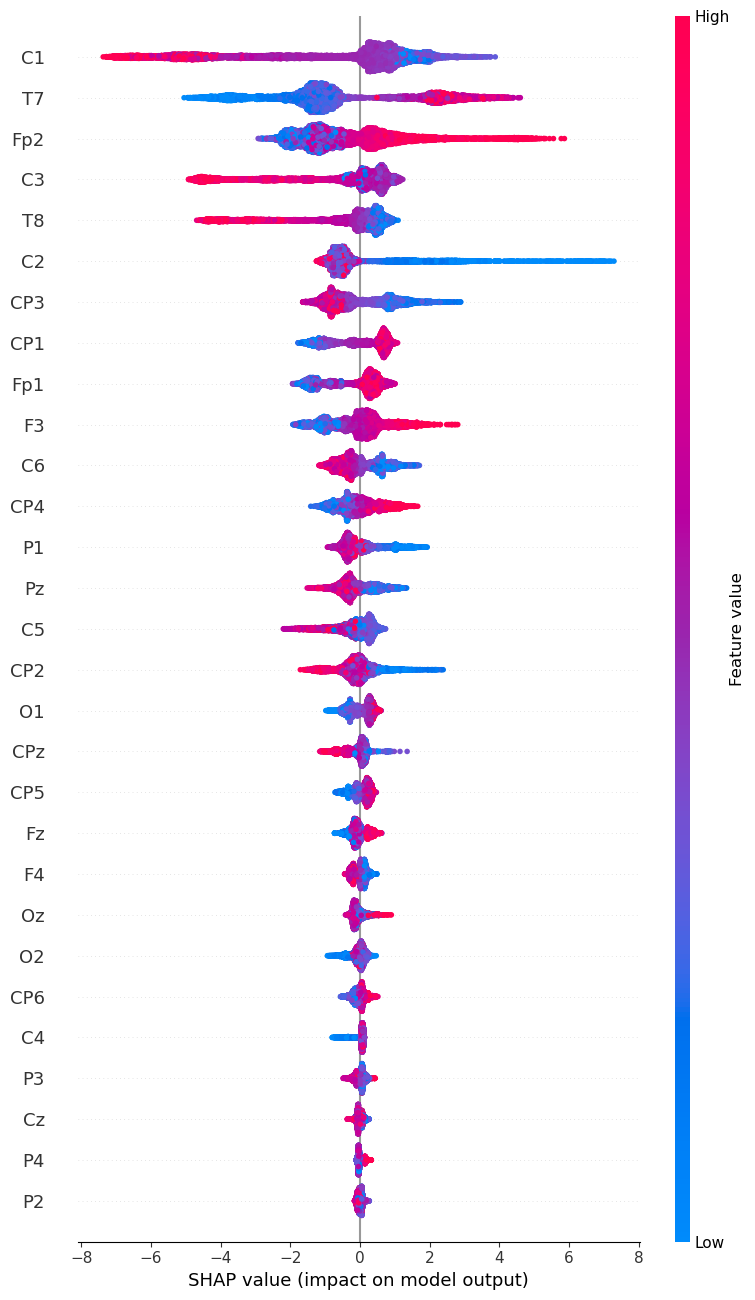

In [8]:
# SHAP値をプロット
shap.summary_plot(shap_values[3], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[1], X_train_df)
# 右足

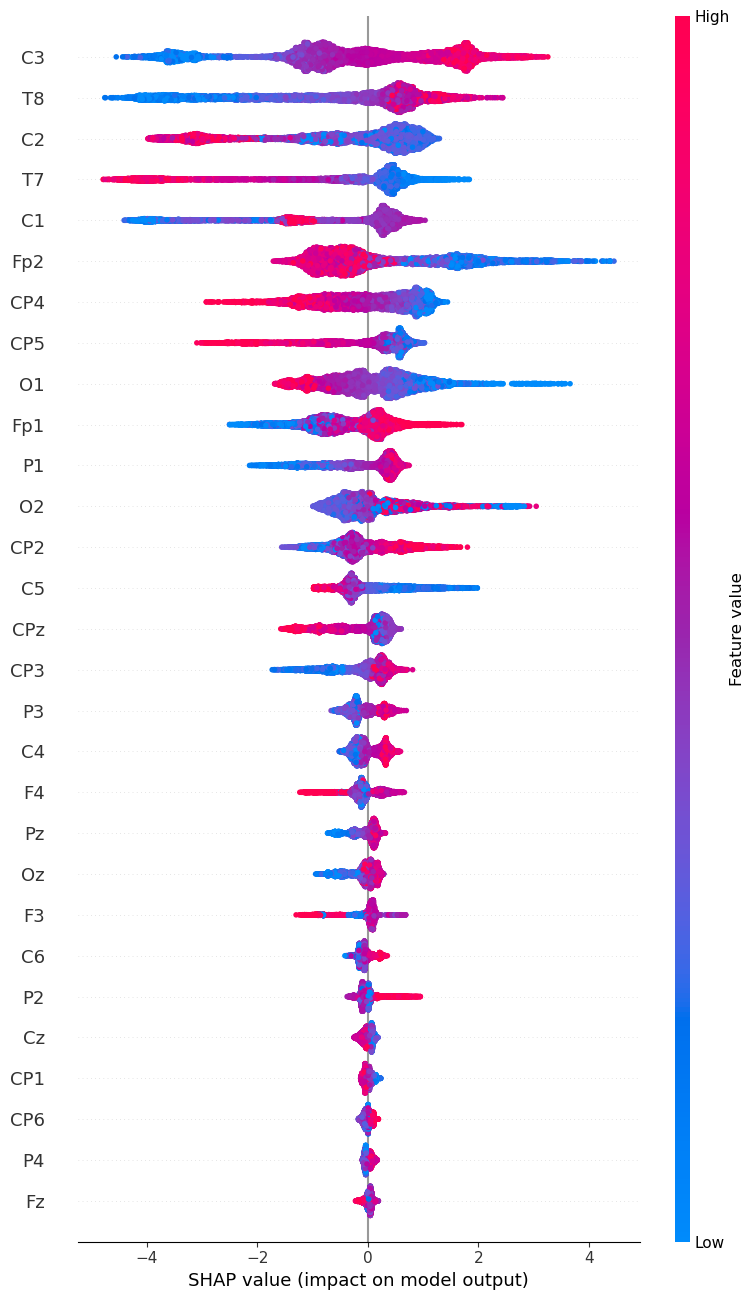

In [9]:
# SHAP値をプロット
shap.summary_plot(shap_values[4], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[1], X_train_df)
# 左足

In [12]:
num_classes = 5  # クラス数を設定
column_names = ['Cz', 'Fz', 'Fp1', 'F3', 'C1', 'C3', 'T7', 'C5', 'CP5', 'CP3', 
        'CP1', 'P1', 'P3', 'O1', 'CPz', 'Pz', 'Oz', 'O2', 'P4', 'P2',
        'CP2', 'CP4', 'CP6', 'C6', 'T8', 'C4', 'C2', 'F4', "Fp2"]
correlation_df = calculate_correlations(shap_values, X_train_df, column_names, num_classes).T
correlation_df

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
feature,Cz,Fz,Fp1,F3,C1,C3,T7,C5,CP5,CP3,...,P2,CP2,CP4,CP6,C6,T8,C4,C2,F4,Fp2
correlation_0,0.82177,-0.808166,-0.046395,-0.729899,0.653235,-0.793818,-0.513121,0.815316,-0.0061,-0.77686,...,0.662427,0.519156,0.681788,0.116001,0.759647,-0.704892,-0.758178,-0.614107,-0.37134,0.794715
correlation_1,-0.702389,-0.63145,-0.926839,0.475272,0.606376,0.357231,0.748789,0.832687,0.759,0.721316,...,0.896987,0.192398,0.783836,-0.84926,-0.816139,0.762237,0.735052,0.794788,0.667461,-0.883061
correlation_2,-0.687647,0.849077,-0.88126,-0.645063,-0.644512,-0.726759,-0.608751,-0.710365,-0.595555,0.769574,...,-0.902848,-0.622151,-0.673175,0.63353,0.594806,-0.804976,0.745695,0.750879,0.882566,-0.812592
correlation_3,-0.297849,0.679235,0.831492,0.736168,-0.67118,-0.572894,0.869782,-0.519274,0.765261,-0.743409,...,-0.358708,-0.649367,0.832,0.648693,-0.773193,-0.852161,0.552706,-0.445132,-0.699328,0.792483
correlation_4,-0.589284,-0.24373,0.825521,-0.231965,0.37999,0.831317,-0.939025,-0.700305,-0.789461,0.7128,...,0.395996,0.80003,-0.859127,0.479058,0.763222,0.844238,0.718644,-0.640712,-0.205176,-0.790509
